In [64]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Maximum Variance: 357.0414053558195


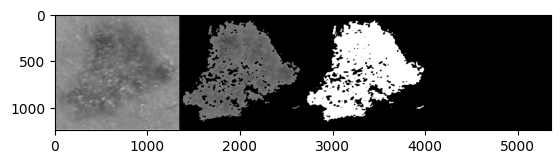

In [65]:
img = cv.imread('cancer.png', cv.IMREAD_GRAYSCALE)

variance = np.var(img)

_, thresh_mask = cv.threshold(img, 0, 255, cv.THRESH_OTSU)

print(f"Maximum Variance: {variance}")

#inverse of image
thresh_mask = 255 - thresh_mask

_, t2 = cv.threshold(img, 0, 1, cv.THRESH_OTSU)

t2 = 1 - t2

filtered = img * t2

plt.imshow(np.hstack([img, filtered, thresh_mask]), cmap='gray')


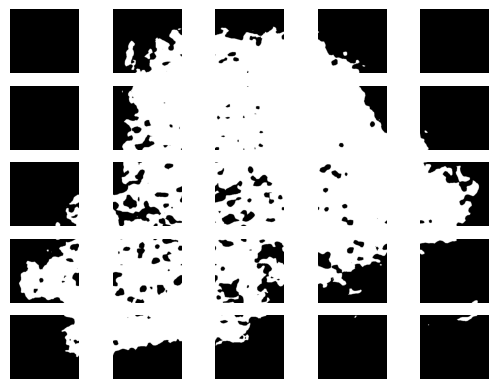

In [66]:
original_image = thresh_mask
height, width = original_image.shape

# Calculate the number of rows and columns for the 5x5 grid
rows = 5
cols = 5

# Calculate the size of each sub-image
sub_image_height = height // rows
sub_image_width = width // cols

# Initialize a list to store sub-images
mask_sub_images = []

# Iterate through each row and column to extract sub-images
for i in range(rows):
    for j in range(cols):
        # Calculate the starting and ending indices for each sub-image
        start_row = i * sub_image_height
        end_row = start_row + sub_image_height
        start_col = j * sub_image_width
        end_col = start_col + sub_image_width

        # Extract the sub-image from the original image
        sub_image = original_image[start_row:end_row, start_col:end_col]

        # Append the sub-image to the list
        mask_sub_images.append(sub_image)

        # Optionally, you can display each sub-image using pyplot
        plt.subplot(rows, cols, i * cols + j + 1)
        plt.imshow(cv.cvtColor(sub_image, cv.COLOR_BGR2RGB))
        plt.axis('off')

# Show the plot with sub-images
plt.show()

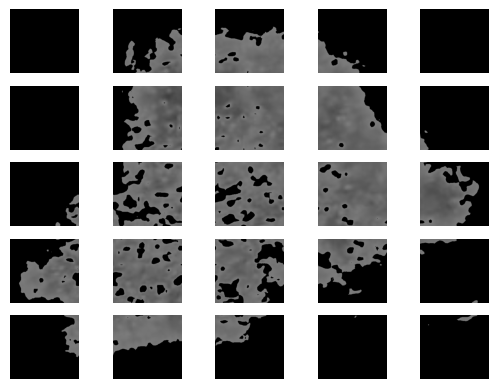

In [67]:
original_image = filtered
height, width = original_image.shape

# Calculate the number of rows and columns for the 5x5 grid
rows = 5
cols = 5

# Calculate the size of each sub-image
sub_image_height = height // rows
sub_image_width = width // cols

# Initialize a list to store sub-images
mask_sub_images = []

# Iterate through each row and column to extract sub-images
for i in range(rows):
    for j in range(cols):
        # Calculate the starting and ending indices for each sub-image
        start_row = i * sub_image_height
        end_row = start_row + sub_image_height
        start_col = j * sub_image_width
        end_col = start_col + sub_image_width

        # Extract the sub-image from the original image
        sub_image = original_image[start_row:end_row, start_col:end_col]

        # Append the sub-image to the list
        mask_sub_images.append(sub_image)

        # Optionally, you can display each sub-image using pyplot
        plt.subplot(rows, cols, i * cols + j + 1)
        plt.imshow(cv.cvtColor(sub_image, cv.COLOR_BGR2RGB))
        plt.axis('off')

# Show the plot with sub-images
plt.show()

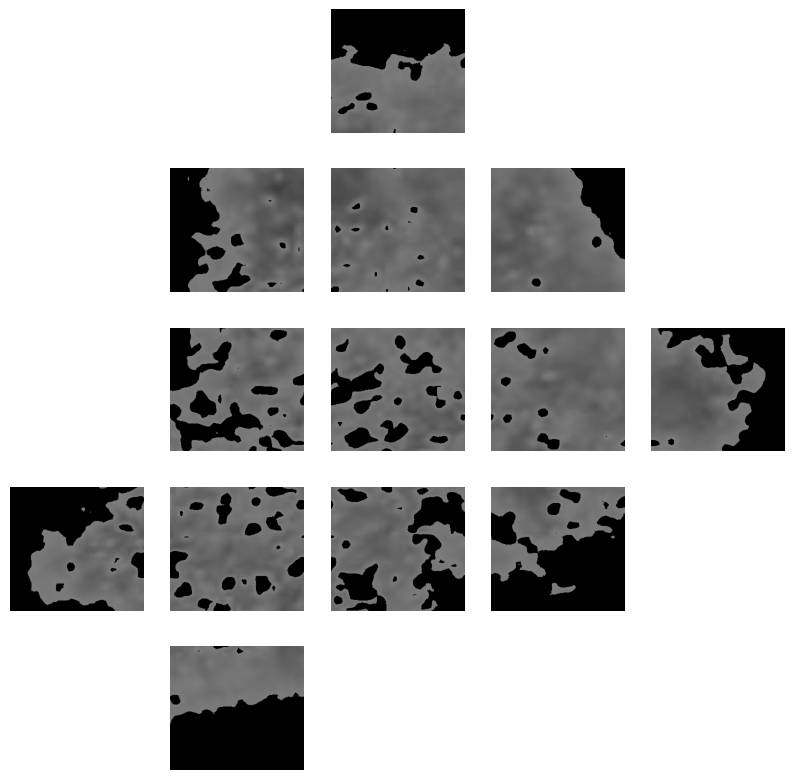

In [68]:
# Assuming you already have two lists of divided images
# filtered_sub_images and mask_sub_images

# Initialize a list to store the selected sub-images
selected_sub_images = []

# Iterate through each pair of filtered and mask sub-images
for filtered_sub_image, mask_sub_image in zip(mask_sub_images, mask_sub_images):
    # Calculate the area of the mask region in the sub-image
    mask_area = np.sum(mask_sub_image > 0)

    # Calculate the threshold based on one-third of the total area of the sub-image
    threshold = (1/3) * np.prod(filtered_sub_image.shape[:2])

    # Check the condition and select the sub-image if the condition is met
    if mask_area >= threshold:
        selected_sub_images.append(filtered_sub_image)
    else:
        selected_sub_images.append(np.ones_like(filtered_sub_image)*255)

# Display the selected sub-images using pyplot
rows = 5
cols = 5

plt.figure(figsize=(10, 10))

for i, sub_image in enumerate(selected_sub_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv.cvtColor(sub_image, cv.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()


uint8
uint8
81
81
255


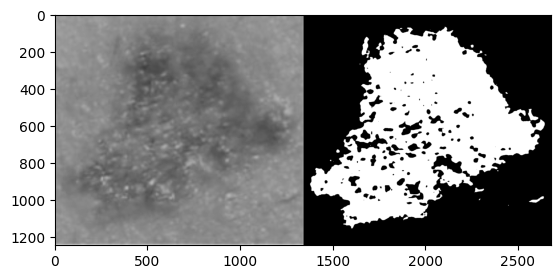